# Runtime Analysis 

During the progress of this project, we initially ran the circuit optimizer and only found total runtime, which is not informative. In this notebook, we import the same circuits and redo the optimization process and compute runtime for various subprocesses.

Importing necessary libraries:

In [2]:
import pickle
from qiskit.quantum_info import Clifford
from qiskit import QuantumCircuit, qasm2
from qiskit.circuit.library import *
from generate_cayley_graph import Node
from testing import *
from shortest_path import *
import pandas as pd
import time
import numpy as np

GateCountRange = range(5,51) #so as to include 50
QubitCountRange = range(2,3) #so as to include 2 (note: we are sticking to 2 qubits)
R = 20 #Number of circuits for given gate and qubit count
gset = [HGate(),CXGate(),SGate()] #CliffordSet

We redefine the optimization subroutine to return individual process times:

In [3]:
def opt_subroutine_multi_times(qc):
    

    with open(f"cayley_graph_2_qubits.pkl", "rb") as f:

        
        nodes = pickle.load(f)

        

        n_qubits = qc.num_qubits
    
    
        identity = Node(Clifford.from_circuit(QuantumCircuit(n_qubits)))

        t_in1 = time.time()
        target = Node(Clifford(qc))
        t_genclifford_obj = time.time() - t_in1 #Time taken to compute Clifford(qc) - should ideally be linear in initial number of gates.

        
        t_in2 = time.time()
        result = dijkstra(nodes, identity.key, target.key)
        t_opt_word = time.time() - t_in2 #Optimization Process Complexity 

        t_in3 = time.time()
        
        qc_opt = QuantumCircuit(n_qubits)
        
        if result is None:
            pass            
        else:
            path, dist = result

            qc_opt = QuantumCircuit(n_qubits)
            for gate in path:
                if gate.startswith("H"):
                    pos = int(gate[1])
                    qc_opt.h(pos)
                elif gate.startswith("S"):
                    pos = int(gate[1])
                    qc_opt.s(pos)
                elif gate.startswith("CX"):
                    ctrl, tgt = int(gate[2]), int(gate[3])
                    qc_opt.cx(ctrl,tgt)

        t_reconstruction = time.time() - t_in3


        return qc_opt, t_genclifford_obj, t_opt_word, t_reconstruction

We read the circuits from the .csv file (due to pandas and numpy having compatibiltiy issues with versions, accessing the pkl file seemed impossible, so we simply obtained it from the CSV, reconstructing the circuits from their corresponding QASM codes). 

In [4]:
df = pd.read_csv('out.csv')
df['Original Circuit'] = [qasm2.loads(x) for x in df['Original Circuit QASM']]
df['Optimized Circuit'] = [qasm2.loads(x) for x in df['Optimized Circuit QASM']]

The optimization process is redone for each of the circuits and updated in the table.

In [5]:
opt_ = []
t_gc = []
t_ow = []
t_rc = []

for qc in df['Original Circuit']:
    qc_opt, t_genclifford_obj, t_opt_word, t_reconstruction = opt_subroutine_multi_times(qc)
    opt_.append(qc_opt)
    t_gc.append(t_genclifford_obj)
    t_ow.append(t_opt_word)
    t_rc.append(t_reconstruction)

df['Optimized Circuit (Redone)'] = opt_
df['Time (Clifford Object)'] = t_gc
df['Time (Optimization Process)'] = t_ow
df['Time (Reconstruction)'] = t_rc

In [14]:
df['Time'] = df['Time (Clifford Object)'] + df['Time (Optimization Process)'] + df['Time (Reconstruction)']

In [15]:
df

,Unnamed: 0,Original Circuit,Original Circuit QASM,Qubit Count,Original Gate Count,Original Depth,H_0,S_0,CX_0,Optimized Circuit,...,Time,% Gate Count Reduction,% Depth Reduction,% H Reduction,% S Reduction,% CX Reduction,Optimized Circuit (Redone),Time (Clifford Object),Time (Optimization Process),Time (Reconstruction)
0,0,"((Instruction(name='h', num_qubits=1, num_clbi...","OPENQASM 2.0;\ninclude ""qelib1.inc"";\nqreg q[2...",2,5,4,3,1,1,"((Instruction(name='h', num_qubits=1, num_clbi...",...,0.004430,40.0,25.000000,66.666667,0.000000,0.000000,"((Instruction(name='h', num_qubits=1, num_clbi...",0.000213,0.003690,0.000527
1,1,"((Instruction(name='cx', num_qubits=2, num_clb...","OPENQASM 2.0;\ninclude ""qelib1.inc"";\nqreg q[2...",2,5,5,1,1,3,"((Instruction(name='h', num_qubits=1, num_clbi...",...,0.001942,40.0,40.000000,0.000000,0.000000,66.666667,"((Instruction(name='h', num_qubits=1, num_clbi...",0.000092,0.001785,0.000065
2,2,"((Instruction(name='cx', num_qubits=2, num_clb...","OPENQASM 2.0;\ninclude ""qelib1.inc"";\nqreg q[2...",2,5,5,0,3,2,"((Instruction(name='cx', num_qubits=2, num_clb...",...,0.002973,0.0,0.000000,0.000000,0.000000,0.000000,"((Instruction(name='cx', num_qubits=2, num_clb...",0.000084,0.002799,0.000090
3,3,"((Instruction(name='s', num_qubits=1, num_clbi...","OPENQASM 2.0;\ninclude ""qelib1.inc"";\nqreg q[2...",2,5,4,0,3,2,"((Instruction(name='s', num_qubits=1, num_clbi...",...,0.001576,40.0,50.000000,0.000000,0.000000,100.000000,"((Instruction(name='s', num_qubits=1, num_clbi...",0.000067,0.001461,0.000048
4,4,"((Instruction(name='s', num_qubits=1, num_clbi...","OPENQASM 2.0;\ninclude ""qelib1.inc"";\nqreg q[2...",2,5,4,0,4,1,"((Instruction(name='s', num_qubits=1, num_clbi...",...,0.002331,0.0,0.000000,0.000000,0.000000,0.000000,"((Instruction(name='s', num_qubits=1, num_clbi...",0.000050,0.002225,0.000056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,915,"((Instruction(name='h', num_qubits=1, num_clbi...","OPENQASM 2.0;\ninclude ""qelib1.inc"";\nqreg q[2...",2,50,39,19,14,17,"((Instruction(name='h', num_qubits=1, num_clbi...",...,0.012417,80.0,79.487179,84.210526,64.285714,88.235294,"((Instruction(name='h', num_qubits=1, num_clbi...",0.000205,0.012130,0.000082
916,916,"((Instruction(name='s', num_qubits=1, num_clbi...","OPENQASM 2.0;\ninclude ""qelib1.inc"";\nqreg q[2...",2,50,41,13,18,19,"((Instruction(name='s', num_qubits=1, num_clbi...",...,0.003564,88.0,87.804878,92.307692,83.333333,89.473684,"((Instruction(name='s', num_qubits=1, num_clbi...",0.000217,0.003299,0.000048
917,917,"((Instruction(name='h', num_qubits=1, num_clbi...","OPENQASM 2.0;\ninclude ""qelib1.inc"";\nqreg q[2...",2,50,40,15,16,19,"((Instruction(name='h', num_qubits=1, num_clbi...",...,0.008121,84.0,82.500000,86.666667,75.000000,89.473684,"((Instruction(name='h', num_qubits=1, num_clbi...",0.000222,0.007828,0.000071
918,918,"((Instruction(name='h', num_qubits=1, num_clbi...","OPENQASM 2.0;\ninclude ""qelib1.inc"";\nqreg q[2...",2,50,42,20,10,20,"((Instruction(name='h', num_qubits=1, num_clbi...",...,0.007224,84.0,90.476190,85.000000,50.000000,100.000000,"((Instruction(name='h', num_qubits=1, num_clbi...",0.000213,0.006958,0.000053


The following code includes preliminary checks for plots. While we use the same data for our final analysis, the plots will be generated separately via MATLAB.

In [7]:
import matplotlib.pyplot as plt



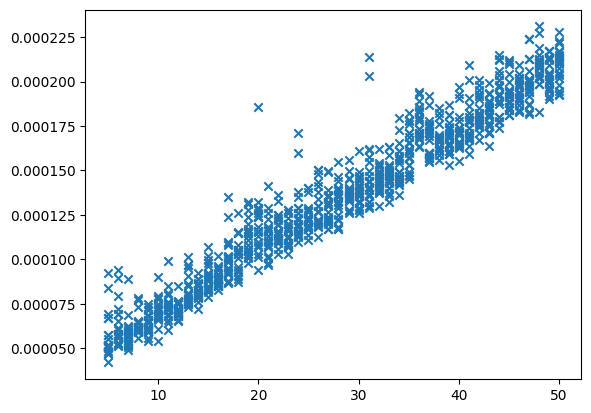

In [8]:
plt.scatter(df['Original Gate Count'][1:],df['Time (Clifford Object)'][1:],marker='x')
mean_times = [0 for i in range(51)]
for i in range(len(df['Original Gate Count'])):
    mean_times[df['Original Gate Count'][i]] += (df['Time (Clifford Object)'][i])/list(df['Original Gate Count']).count(df['Original Gate Count'][i])


#plt.plot(range(51),mean_times)

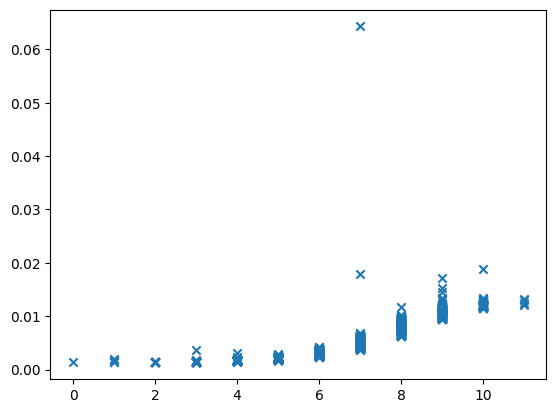

In [11]:
plt.scatter(df['Optimized Gate Count'],df['Time (Optimization Process)'],marker='x')

mean_times = [0 for i in range(12)]

for i in range(len(df['Optimized Gate Count'])):
    mean_times[df['Optimized Gate Count'][i]] += (df['Time (Optimization Process)'][i])/list(df['Optimized Gate Count']).count(df['Optimized Gate Count'][i])

#plt.plot(range(12),mean_times)

    

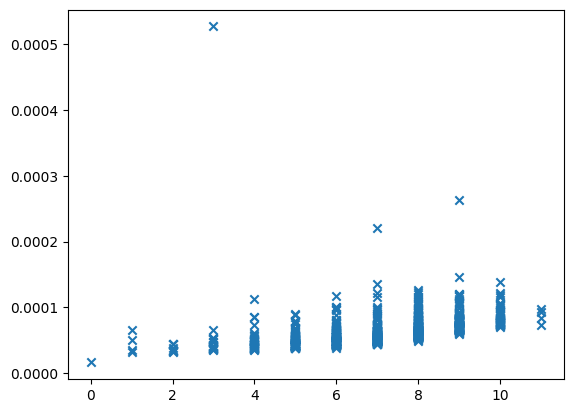

In [10]:
plt.scatter(df['Optimized Gate Count'],df['Time (Reconstruction)'],marker='x')

Sanity Check - are the circuits the same? 

In [13]:
set(df['Optimized Circuit'] == df['Optimized Circuit (Redone)'])

{True}

Since there are no FALSE outputs, this indicates that we are good. 

In [16]:
df.to_csv('out_runtimes_updated.csv')